# Tutorial: Integration of pancreas islet cell data collected using five different technologies

This tutorial demonstrates how to use HD-AE to integrate scRNA-seq data from different sources. In this tutorial we'll be considering a set of pancreas islet data collected by five different laboratories, each using a different scRNA-seq protocol. This data used in this tutorial can be downloaded using the <a href="https://github.com/satijalab/seurat-data">SeuratData R package</a> as the "panc8" dataset.

---

## Tutorial Goals:

The following is short a walkthrough of a typical scRNA-seq alignment problem that `HD-AE` is designed to solve. Our goals here are:

1. Learn a low-dimensional embedding space in which cells group by meaningful biological variations rather than nuisance factors (e.g. scRNA-seq technology)
2. Use such a space to perform downstream analysis tasks

---

## The data:

Our data consists of 14,890 cells, the expression levels of which were measured using five different scRNA-seq technologies. For convenience we provide a preprocessed version of the data available for download here that has already been filtered down to the 2000 most variable genes and has been normalized using the <a href="https://satijalab.org/seurat/">Seurat R package</a>. The `HD-AE` codebase was designed for use with the <a href="https://scanpy.readthedocs.io/en/stable/">scanpy</a> Python package, which we will use here to read in and visualize our data.

First, we'll verify that the data does indeed have strong batch effects using the UMAP dimensionality reduction algorithm. Our provided dataset has been annotated with the technology used to collect it as well as ground-truth cell types, making it easy to confirm the presence batch effects. 

         Falling back to preprocessing with `sc.pp.pca` and default params.


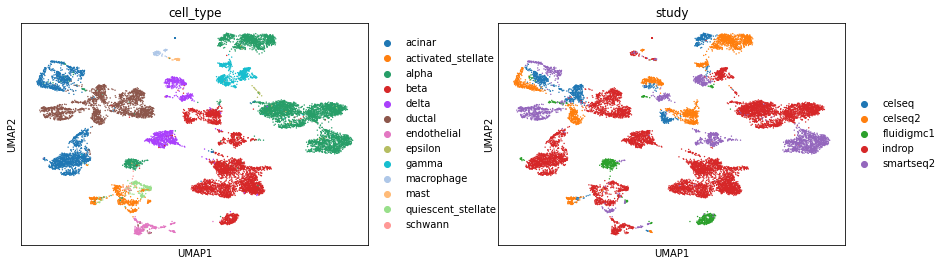

In [1]:
import scanpy as sc
from hd_ae import set_seeds

set_seeds() # To ensure reproducibility
adata = sc.read("datasets/pancreas.h5ad")

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'study'], wspace=0.25)

From our UMAP plots, we can see the data has _strong_ batch effects; it separates almost perfectly by batch, and cells from the same cell type are often broken up into multiple distinct clusters based on their batch of origin.

---

## HD-AE setup:

The low-level details of HD-AE have been abstracted away into a single `HD_AE` class that performs model training with just a few API calls. The `HD_AE` class requires at initialization time an AnnData object along with the name of the field used to denote each sample's batch of origin in the `obs` field of your AnnData object (`batch_key`). The values of HD-AE's hyperparameters can also be set here. We do them explicitly in this tutorial to illustrate the process, though these fields can also be left blank to use a reasonable default set of hyperparameters.

In [2]:
from hd_ae import HD_AE

model = HD_AE(
    adata,
    batch_key='study',
    hidden_layer_sizes=[500, 250],
    learning_rate = 1e-3,
    embedding_dimension=50,
    hsic_penalty = 1
)

## Training the model:

Once defined, the model can be trained with a single call to the `train` function.

In [3]:
model.train(num_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.1 M 
1 | decoder   | Sequential | 1.1 M 
2 | criterion | MSELoss    | 0     
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.119     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/117 [00:00<?, ?it/s] 

/homes/gws/ewein/miniconda3/envs/HD-AE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 99: 100%|██████████| 117/117 [00:01<00:00, 68.59it/s, loss=0.0667, v_num=20, reconstruction_loss=0.0622, HSIC_loss=0.00102] 


Once trained, the HD-AE model can be used to produce integrated sets of low-dimensional embeddings.

In [4]:
hd_ae_embeddings = model.embed_data(adata)

Now we use UMAP plots to quickly verify that our embeddings have been correctly integrated across batches:

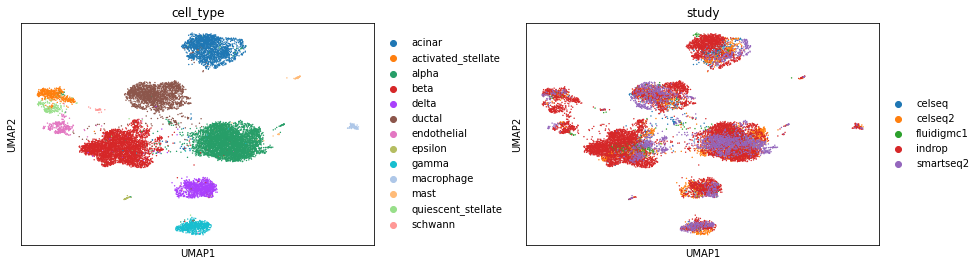

In [5]:
sc.pp.neighbors(hd_ae_embeddings)
sc.tl.umap(hd_ae_embeddings)
sc.pl.umap(hd_ae_embeddings, color=['cell_type', 'study'], wspace=0.3)

Based on our UMAP plots we can see that our data points cluster based on cell type and are mixed across the different technologies!